In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [134]:
data = pd.read_csv('../data/num_file/min_01/p040.csv')

In [135]:
print(data)

                   datetime  count
0       2022-04-21 01:40:00     23
1       2022-04-21 01:41:00    150
2       2022-04-21 01:42:00     27
3       2022-04-21 01:43:00      0
4       2022-04-21 01:44:00      0
...                     ...    ...
194995  2022-09-03 11:35:00    310
194996  2022-09-03 11:36:00    461
194997  2022-09-03 11:37:00    503
194998  2022-09-03 11:38:00    473
194999  2022-09-03 11:39:00    423

[195000 rows x 2 columns]


If there is no people, use NaN.

In [136]:
data.loc[data['count']==0, 'count'] = np.NaN

In [137]:
print(data)

                   datetime  count
0       2022-04-21 01:40:00   23.0
1       2022-04-21 01:41:00  150.0
2       2022-04-21 01:42:00   27.0
3       2022-04-21 01:43:00    NaN
4       2022-04-21 01:44:00    NaN
...                     ...    ...
194995  2022-09-03 11:35:00  310.0
194996  2022-09-03 11:36:00  461.0
194997  2022-09-03 11:37:00  503.0
194998  2022-09-03 11:38:00  473.0
194999  2022-09-03 11:39:00  423.0

[195000 rows x 2 columns]


<Axes: >

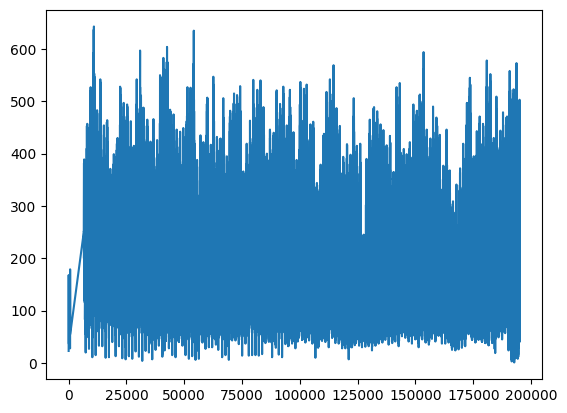

In [138]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

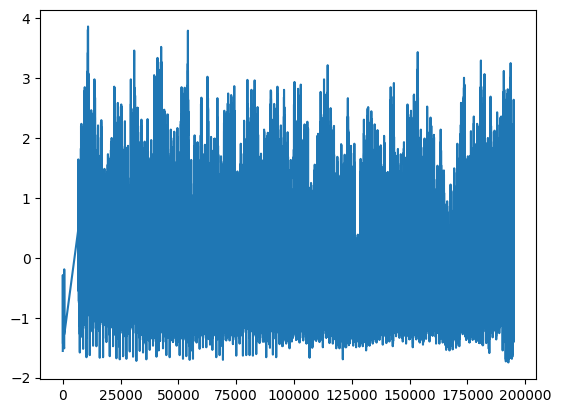

In [139]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [140]:
print(data)

                   datetime     count
0       2022-04-21 01:40:00 -1.554014
1       2022-04-21 01:41:00 -0.443766
2       2022-04-21 01:42:00 -1.519046
3       2022-04-21 01:43:00 -1.476925
4       2022-04-21 01:44:00 -1.434803
...                     ...       ...
194995  2022-09-03 11:35:00  0.954972
194996  2022-09-03 11:36:00  2.275031
194997  2022-09-03 11:37:00  2.642200
194998  2022-09-03 11:38:00  2.379936
194999  2022-09-03 11:39:00  1.942831

[195000 rows x 2 columns]


In [141]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 10

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [142]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [143]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [144]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [145]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [146]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)

In [147]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [148]:
decoder = RepeatVector(time_step)(encoder_last_h1)
decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [149]:
out = TimeDistributed(Dense(time_step))(decoder)

In [150]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 32),      │      4,352 │ input_layer_10[0… │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm_10[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 10, 32)    │          0 │ batch_normalizat… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm_10[0][2]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 10, 32)    │      8,320 │ repeat_vector_3[… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 10, 10)    │        330 │ lstm_11[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,258 (51.79 KB)

 Trainable params: 13,130 (51.29 KB)

 Non-trainable params: 128 (512.00 B)

In [151]:
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1)

Epoch 1/100


1097/1097 ━━━━━━━━━━━━━━━━━━━━ 215s 194ms/step - loss: 0.0731 - mae: 0.1763 - val_loss: 0.0554 - val_mae: 0.1770
Epoch 2/100
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 226s 206ms/step - loss: 0.0352 - mae: 0.1276 - val_loss: 0.0307 - val_mae: 0.1193
Epoch 3/100
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 202s 184ms/step - loss: 0.0216 - mae: 0.1015 - val_loss: 0.0172 - val_mae: 0.0948
Epoch 4/100
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 208s 189ms/step - loss: 0.0170 - mae: 0.0897 - val_loss: 0.0611 - val_mae: 0.1809
Epoch 5/100
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 210s 191ms/step - loss: 0.0268 - mae: 0.1134 - val_loss: 0.0190 - val_mae: 0.0993
Epoch 6/100
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 200s 182ms/step - loss: 0.0137 - mae: 0.0798 - val_loss: 0.0141 - val_mae: 0.0849
Epoch 7/100
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 207s 189ms/step - loss: 0.0106 - mae: 0.0689 - val_loss: 0.0100 - val_mae: 0.0698
Epoch 8/100
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 203s 185ms/step - loss: 0.0087 - mae: 0.0605 - val_loss: 0.0086 - val_mae: 0.0567
Epoch 9/100


KeyboardInterrupt: 